# Quantum Simulations in Simphony

In [1]:
import gdsfactory as gf
import simphony
import simphony.libraries.siepic as siepic
from simphony.models import Model
from simphony.layout import Circuit
from simphony.tools import wl2freq, freq2wl
from simphony.quantum import SqueezedState, CoherentState, compose_qstate
import ubcpdk
import yaml
from scipy.interpolate import interp1d
import pickle
import numpy as np
import ipywidgets as ipw
from matplotlib import cm, pyplot as plt, ticker
from scipy.constants import pi, hbar

2023-03-06 14:56:17.672 | INFO     | gdsfactory.config:<module>:50 - Load 'C:\\Users\\capta\\gdsfactory\\gdsfactory' 6.29.3
2023-03-06 14:56:19.156 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: C:\Users\capta\gdsfactory\gdsfactory\generic_tech\klayout\tech\layers.lyp.
2023-03-06 14:56:22.611 | INFO     | ubcpdk:<module>:35 - Found UBCpdk '1.16.0' installed at WindowsPath('C:/Users/capta/ubc/ubcpdk')
2023-03-06 14:56:22.616 | INFO     | gdsfactory.pdk:register_cells_yaml:225 - Registered cell 'grating'
2023-03-06 14:56:22.618 | INFO     | gdsfactory.pdk:register_cells_yaml:225 - Registered cell 'mask'
2023-03-06 14:56:22.619 | INFO     | gdsfactory.pdk:register_cells_yaml:225 - Registered cell 'mzi_lattice_filter'
2023-03-06 14:56:22.619 | INFO     | gdsfactory.pdk:register_cells_yaml:225 - Registered cell 'mzi_ubcpdk'
2023-03-06 14:56:22.620 | INFO     | gdsfactory.pdk:register_cells_yaml:225 - Registered cell 'pa

### Circuit Layout and Instantiation using GDSFactory
We first layout our photonic circuit using components from the UBC SiEPIC PDK. We then instantiate the circuit using the GDSFactory which also automatically generates a layout for the circuit. With this we can create a netlist and import it into Simphony to simulate not only how the circuit will behave classically but also how it will behave quantum mechanically or with different quantum inputs.

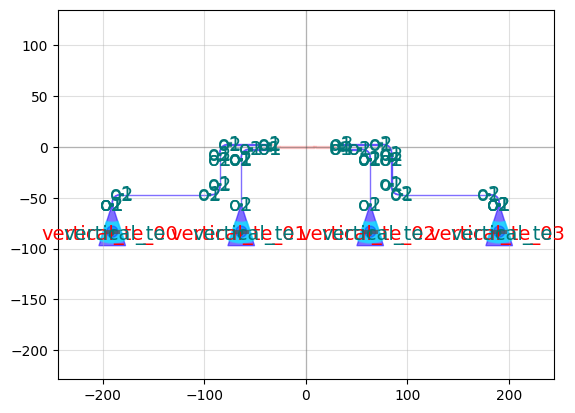

In [2]:
bcd = ubcpdk.components.ebeam_bdc_te1550()
circuit = gf.routing.add_fiber_array(bcd, with_loopback=False)
circuit.write_netlist('mynetlist.yml')
circuit.plot()

### Import Netlist into Simphony
In order to import the netlist into Simphony we must define models for the components. Simphony already has many models for components in the UBC SiEPIC PDK. We can use these models with out much effort. The only element that doesn't already exist in Simphony is the euler bend so we must generate a model for this element. We can do this by creating a new model in Simphony and then using the model but we also need s-parameters for this devices. Using GDSFactory one can quickly generate the s-parameters using a quick simulation in tidy3d, Meep or Lumerical. Here for brevity we just import a previouly simulated s-params from Meep saved in the sp.pkl file.

In [3]:
class bend_euler(Model):
    pin_count=2
    with open('sp.pkl', 'rb') as f:
        sp = pickle.load(f)
    s11 = sp['o1@0,o1@0']
    s12 = sp['o1@0,o2@0']
    s21 = sp['o2@0,o1@0']
    s22 = sp['o2@0,o2@0']
    freqs = wl2freq(sp['wavelengths']*1e-6)

    def s_parameters(self, freqs):
        # interpolate s parameters for the given frequencies
        s11 = interp1d(self.freqs, self.s11)(freqs)
        s12 = interp1d(self.freqs, self.s12)(freqs)
        s21 = interp1d(self.freqs, self.s21)(freqs)
        s22 = interp1d(self.freqs, self.s22)(freqs)
        return np.stack([s11, s12, s21, s22], axis=1).reshape(-1, 2, 2)

models = {
    'grating_coupler_elliptical_trenches': siepic.GratingCoupler, 
    'straight': siepic.Waveguide,
    'bend_euler': bend_euler,
    'ebeam_bdc_te1550': siepic.BidirectionalCoupler
}

smphny_crkt = Circuit.from_netlist('mynetlist.yml', models=models)


At this point we can do any classical simulation in Simphony that we would like. Here are are the s-parameters for the entire circuit. 

In [4]:
amp = smphny_crkt.s_parameters([wl2freq(1550e-9)])[0, :, :, 0]
phi = smphny_crkt.s_parameters([wl2freq(1550e-9)])[0, :, :, 1]
re = amp*np.cos(phi)
im = amp*np.sin(phi)
print(amp, phi, re, im)

[[0.07524987 0.0173323  0.39566027 0.38911827]
 [0.01739923 0.07203664 0.39203766 0.39505026]
 [0.39568468 0.39038166 0.08873921 0.00576742]
 [0.39060458 0.39504431 0.00578104 0.06921549]] [[-0.3853984  -6.69164357 -2.09542222  2.43473667]
 [-6.69145396 -0.38546004 -7.89029678 -0.21740982]
 [-2.09531986 -7.89018973 -0.31141321  2.99424263]
 [ 2.43464366 -0.21740782  2.99359591 -6.66959461]] [[ 0.0697302   0.01590644 -0.19818198 -0.29588845]
 [ 0.01596918  0.06675099 -0.01423377  0.38575055]
 [-0.19815915 -0.01413189  0.08447099 -0.00570492]
 [-0.29699505  0.38574491 -0.00571784  0.06411211]] [[-0.02828856 -0.0068843  -0.34244847  0.2527114 ]
 [-0.00690786 -0.02708473 -0.39177918 -0.08521279]
 [-0.34248988 -0.39012579 -0.02719006  0.00084676]
 [ 0.2537043  -0.08521074  0.00085245 -0.02608489]]


### Quantum Simulation using Simphony
Simphony can convert the classical circuit into a quantum circuit that takes into account extra quantum effects such as accounting for extra vacuum modes. With this information Simphony recalculated the s-parameters for the circuit to account for these effects.

In [5]:
from simphony.quantum import Qcircuit

q_ckt = Qcircuit(circuit=smphny_crkt, pins=('in1', 'in2', 'out1', 'out2'))

In this example we simulate what happens when we apply a strong local oscillator to one input and a vacuum squeezed state to the other input. We can see that the output is a squeezed state when the local oscillator is in phase with the squeezing angle we get less noise than the vacuum. This circuit is quite lossy so the amount of visible squeezing is quite small. Also the balance detection output is not centered around 0 only becuase the circuit splitting is not perfect so there will be a DC offset. This can be mitigated by using some of simphony's built in simulation tools which can model physical detectors with bandwidths and noise.

In [6]:
def get_dist(bs, state):
    _, qstate = bs.quantum_transform(state, np.array([wl2freq(1550e-9)]))
    qstate = qstate[0]
    x1, x2, p1, p2 = np.random.multivariate_normal(qstate.means, qstate.cov, 10000).T
    port1 = (x1**2 + p1**2)
    port2 = (x2**2 + p2**2)

    # balance detection
    out = port1 - port2

    left, right = 0, 0.5e6
    bins = np.arange(left, right, (right-left)/101)
    bin_centers = (bins[1:] + bins[:-1]) / 2
    bin_counts = np.histogram(out, bins=bins)[0]
    bin_probs = bin_counts / len(out)
    return bin_centers, bin_probs, qstate

In [7]:
%matplotlib widget

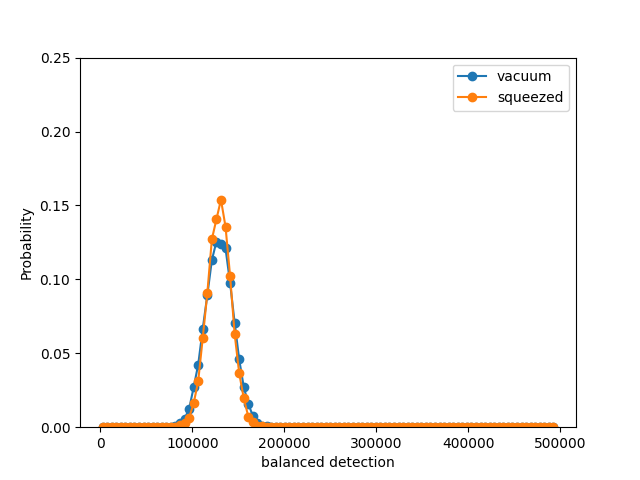

interactive(children=(FloatSlider(value=2.43, description='phi', max=3.141592653589793, step=0.001), Output())…

<function __main__.update(phi=2.43)>

In [10]:
# experiment setup
wl = 1550e-9
omega = 2 * pi * 3e8 / wl
sampling_freq = 1e9
hffs = hbar * omega * sampling_freq
lo_power = 100e-3 # W

# signal
n = 0
alpha = np.sqrt(n)
phi_init = 2.43
rect = alpha * np.exp(1j * phi)
r_init=3

# signal = CoherentState(alpha=rect, pin=q_ckt.pins["in1"])
signal = SqueezedState(r=r_init, phi=0, pin=q_ckt.pins["in1"])

vacuum = CoherentState(alpha=0, pin=q_ckt.pins["in1"])
lo = CoherentState(alpha=np.sqrt(lo_power/hffs)*np.exp(1j*phi_init), pin=q_ckt.pins["in2"])
vac_state = compose_qstate(vacuum, lo)
state = compose_qstate(signal, lo)

vac_bin_centers, vac_bin_probs, qstate = get_dist(q_ckt, vac_state)
bin_centers, bin_probs, qstate = get_dist(q_ckt, state)

# plot each bins probability
plt.figure()
vac_line, = plt.plot(vac_bin_centers, vac_bin_probs, 'o-', label='vacuum')
line, = plt.plot(bin_centers, bin_probs, 'o-', label='squeezed')
plt.ylim(0, 0.25)
plt.legend()
plt.ylabel('Probability')
plt.xlabel('balanced detection')
plt.show()

def update(phi=phi_init):
    signal = SqueezedState(r=r_init, phi=0, pin=q_ckt.pins["in1"])
    lo = CoherentState(alpha=np.sqrt(lo_power/hffs)*np.exp(1j*phi), pin=q_ckt.pins["in2"])
    state = compose_qstate(signal, lo)
    
    bin_centers, bin_probs, qstate = get_dist(q_ckt, state)
    line.set_ydata(bin_probs)
    pass


ipw.interact(update, phi = (0, np.pi, 0.001))
